In [1]:
import os
import pyemma
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

DE Shaw's dcd file and topology pdb file.

In [2]:
dcd_file = r"E:\chignolin_results\DEShaw_research_chignolin\DESRES-Trajectory_CLN025-0-protein\DESRES-Trajectory_CLN025-0-protein\CLN025-0-protein"  # DCD 文件路径
topology_file = r"C:\Users\Administrator\Desktop\GFM\pdb_data\test.pdb"  # PDB 文件路径

dcd_files = [os.path.join(dcd_file, f) for f in os.listdir(dcd_file) if f.endswith('.dcd')]
dcd_files.sort()

Load dcd files by topology file

In [3]:
traj = md.load(dcd_files, top=topology_file)
x = traj.xyz

To calculate the RMSD, the reference chignolin structure is either the one in the topology file or the structure at frame 1500 in the `CLN025-0-protein-000.dcd` file.

In [4]:
reference = md.load_dcd(dcd_file + '/CLN025-0-protein-000.dcd', top=topology_file)
# reference = md.load_dcd('ref.dcd', top=topology_file)

CA_atoms = reference.topology.select('name CA and resid 2 to 36')

rmsd = []

for traj_name in dcd_files:
    traj = md.load_dcd(traj_name, top=topology_file)
    for element in md.rmsd(traj, reference, 1500, atom_indices=CA_atoms):
    # for element in md.rmsd(traj, reference, 0, atom_indices=CA_atoms):
        rmsd.append(element)
# to Angstrom
rmsd = np.array(rmsd) * 10.0

Plot a histogram of all RMSD values.

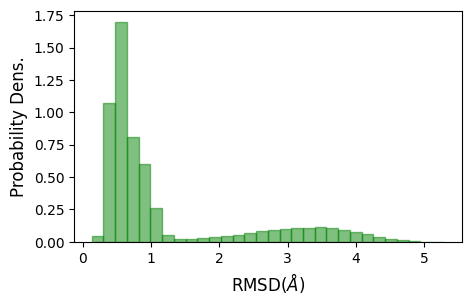

In [5]:
# histogram
fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd, density=True, bins=30, color='g', alpha=0.5, edgecolor='g')
ax1.set_xlabel('RMSD$(\AA)$', fontsize=12)
ax1.set_ylabel('Probability Dens.', fontsize=12)
plt.show()

By setting an RMSD threshold, the conformations can be classified into folded and unfolded states:  
(1) structures with RMSD greater than the threshold are considered **unfolded**,  
(2) while those with RMSD less than the threshold are considered **folded**.

In [6]:
threshold = 1.4   # RMSD threshold, unit is angstrom

above_threshold = rmsd > threshold
below_threshold = rmsd <= threshold

above_indices = np.where(above_threshold)[0]
below_indices = np.where(below_threshold)[0]

above_values = rmsd[above_threshold]
below_values = rmsd[below_threshold]

print(f"Indices with values greater than {threshold} nm: {above_indices}")
print(f"Values greater than {threshold} nm: {above_values}")
print(f"Indices with values less than or equal to {threshold} nm: {below_indices}")
print(f"Values less than or equal to {threshold} nm: {below_values}")
print(f"\nStatistics:")
print(f"Total data points: {len(rmsd)}")
print(f"Number of values greater than {threshold} nm: {len(above_values)} ({len(above_values)/len(rmsd):.1%})")
print(f"Number of values less than or equal to {threshold} nm: {len(below_values)} ({len(below_values)/len(rmsd):.1%})")


# ------------------------ #
x0 = x[above_indices, :, :]
x1 = x[below_indices, :, :]

Indices with values greater than 1.4 nm: [   661    833    875 ... 524740 524741 524742]
Values greater than 1.4 nm: [1.6344298 1.4568293 1.4504316 ... 4.022769  3.8696828 3.6107569]
Indices with values less than or equal to 1.4 nm: [     0      1      2 ... 524625 524627 524629]
Values less than or equal to 1.4 nm: [0.53647643 0.6511762  0.5932692  ... 1.2760979  1.3939426  1.3130817 ]

Statistics:
Total data points: 524743
Number of values greater than 1.4 nm: 114922 (21.9%)
Number of values less than or equal to 1.4 nm: 409821 (78.1%)


In [7]:
features = pyemma.coordinates.featurizer(topology_file)
features.add_residue_mindist()

08-04-25 19:25:21 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


Compute TICA using all DE Shaw data and obtain the FES (Free Energy Surface) plot of the dataset. Based on the TICA computed from all the data, calculate the positions of the classified \( x_0 \) (folded state) and \( x_1 \) (unfolded state) on the FES plot.

C:\Users\Administrator\anaconda3\envs\mfm\Lib\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from C:\Users\Administrator\anaconda3\envs\mfm\Lib\site-packages\decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


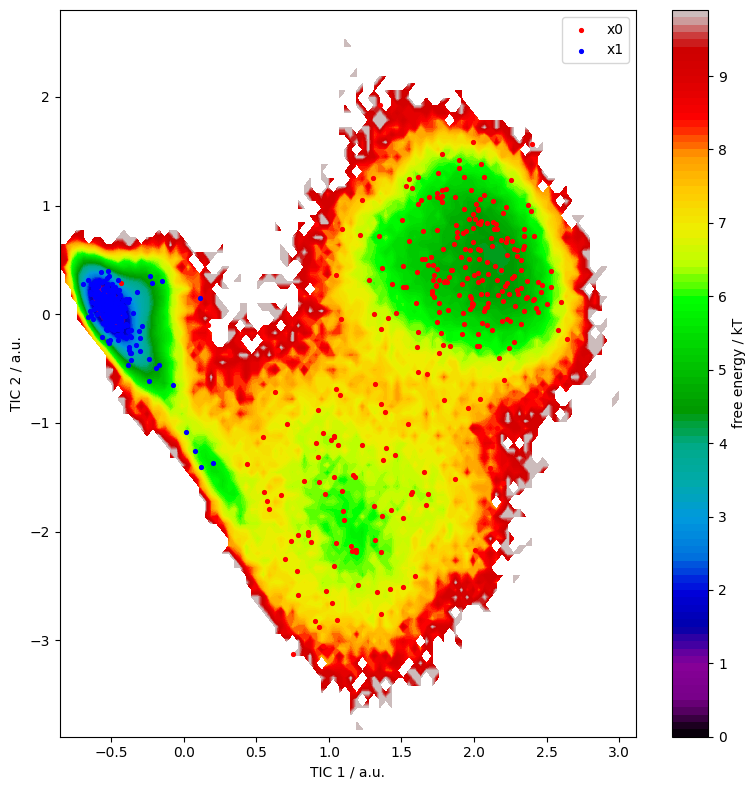

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
source_dcd = pyemma.coordinates.source([dcd_files], features=features, chunksize=x.shape[0])
tica = pyemma.coordinates.tica(data=source_dcd, lag=10, dim=2)
tica_result_d = tica.get_output()[0]

tica_result = tica_result_d
x0_indices = np.random.choice(above_indices, size=300, replace=False)
x1_indices = np.random.choice(below_indices, size=300, replace=False)

pyemma.plots.plot_free_energy(*tica_result.T, ax=axes)

axes.scatter(*tica_result[x0_indices, :].T, marker='.', c='r', s=30, label='x0')
axes.scatter(*tica_result[x1_indices, :].T, marker='.', c='b', s=30, label='x1')

axes.legend()
axes.set_xlabel('TIC 1 / a.u.')
axes.set_ylabel('TIC 2 / a.u.')

fig.tight_layout()

plt.show()